In [15]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

# Launch DPS for 3.1.2_dps.py
multi-spectral composites


In [4]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
!pip install xmltodict
!pip install s3fs
import s3fs
import xmltodict

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.1/136.1 KB 2.0 MB/s eta 0:00:0000:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached xmltodict-0.12.0-py2.py3-none-any.whl (9.2 kB)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Show status of MS composites for boreal tiles: find tiles still NEEDED
    Colored tiles indicate those still needed - water tiles removed
    BLACK tiles are processed

In [5]:
def GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS',
                    boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
                    GROUP_FIELD = 'tile_group',
                    tindex_master_fn = '/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/HLS_tindex_master.csv',#'s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/HLS_tindex_master.csv',
                    topo_tindex_master_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv',
                    bad_tiles = [3540,3634,3728,3823,3916,4004], #Dropping the tiles near antimeridian that reproject poorly.
                    REMOVE_BAD_TILES = False,
                    REDO_TILES_LIST = None,
                    FIND_TILE_GROUP = None
                   ):

    # Get all boreal tiles
    #shared-buckets/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg
    boreal_tile_index = gpd.read_file(boreal_tile_index_path)
    
    if REMOVE_BAD_TILES:
        # Remove bad tiles
        boreal_tile_index = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]

    hls_tindex_master = pd.read_csv(tindex_master_fn)
    topo_tindex_master = pd.read_csv(topo_tindex_master_fn)
    hls_tindex = boreal_tile_index.merge(hls_tindex_master[['tile_num','s3_path','local_path']], how='right', on='tile_num')
    topo_tindex = boreal_tile_index.merge(topo_tindex_master[['tile_num','s3_path','local_path']], how='right', on='tile_num')
    
    if REDO_TILES_LIST is not None:
        redo_hls_tindex = hls_tindex[hls_tindex['tile_num'].isin(REDO_TILES_LIST)]
        return redo_hls_tindex
    else:
        print(boreal_tile_index.groupby(GROUP_FIELD)[GROUP_FIELD].agg(['count']))

        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = [16, 16]

        print(f"Tile status report for {DPS_DATA_TYPE} from {tindex_master_fn}:")
        print(f'\t# of boreal tiles in boreal v003:\t\t\t{len(boreal_tile_index)}')

        # Get water tiles
        water_tiles = list(set(boreal_tile_index.tile_num) - set(topo_tindex.tile_num) )
        print(f'\t# of boreal tiles in water:\t\t\t\t{len(water_tiles)}')

        NUM_STUDY_TILES = len(boreal_tile_index[~boreal_tile_index['tile_num'].isin(water_tiles)])
        print(f'\t# of boreal tiles used study (from Topo coverage):\t{NUM_STUDY_TILES}')

        ax = boreal_tile_index[~boreal_tile_index['tile_num'].isin(water_tiles)].plot(column=GROUP_FIELD, legend=True)
        #ax = tiles_topo_index.plot(color='gray', ax=ax)
        ax = hls_tindex.plot(color='black', ax = ax)
        print(f'\t# of boreal tiles with {DPS_DATA_TYPE}:\t\t\t\t{len(hls_tindex)}')

        needed_tindex = boreal_tile_index[~boreal_tile_index['tile_num'].isin(hls_tindex.tile_num.to_list() + water_tiles)]
        
        if FIND_TILE_GROUP is not None:
            needed_tindex = needed_tindex[needed_tindex[GROUP_FIELD] == FIND_TILE_GROUP]
        else:
            FIND_TILE_GROUP = 'all'
        LIST_TILES_NEEDED = needed_tindex.tile_num.to_list()
        print(f'\t# of boreal tiles still needing {DPS_DATA_TYPE} from {FIND_TILE_GROUP}:\t{len(LIST_TILES_NEEDED)}')
        # The next 100 tiles in line for processing
        #needed_tindex.iloc[0:100].plot(color='#525252', ax = ax)
        needed_tindex.plot(color='#525252', ax = ax)
        
        return LIST_TILES_NEEDED


/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		HLS
Year:		2022
Month:		03
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists
                                             s3_path  ...                                file
0  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...     HLS_7_06-01_09-15_2019_2021.tif
1  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_178_06-01_09-15_2019_2021.tif
2  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_275_06-01_09-15_2019_2021.tif
3  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_3848_06-01_09-15_2019_2021.tif
4  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...     HLS_4_06-01_09

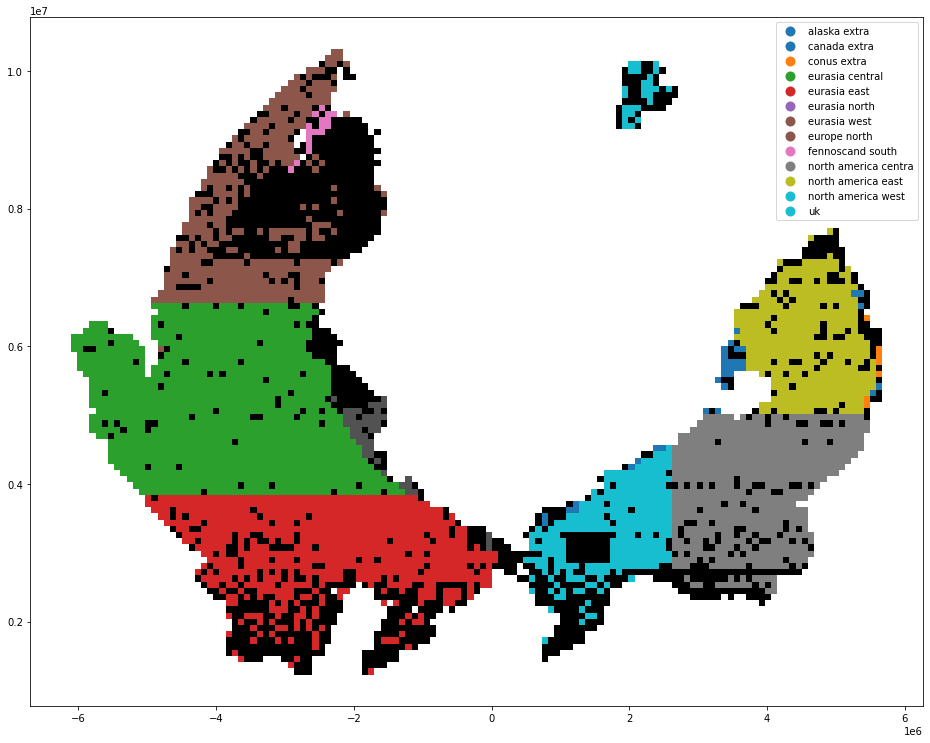

In [7]:
!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m 03

HLS_TILES_NEEDED = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', FIND_TILE_GROUP = 'eurasia north', tindex_master_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv')

In [8]:
INPUT_TILE_NUM_LIST = HLS_TILES_NEEDED
len(INPUT_TILE_NUM_LIST)


45

#### Search for tiles that need to be redone due to artifacts
    + artifacts are scene-induced - where max_cloud = 25 was a bit too harsh
    + manually specify a redo tiles list after inspecting MS comps
    + delete the existing tile dirs for those tiles

In [94]:
REDO_TILES = [
                1043, 1044, \
                34675, 34674, 34676, 35126, 35125, 35352, 1216,
                3193, 3286, 3380, 3938, 3949
             ]

REDO_TILES = [3090, 3833, 3920, 701, 747, 35577, 34443, 3949, 1044, 3470]
# Get the tindex of the REDOs
redo_hls_tindex = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', REDO_TILES_LIST = REDO_TILES)

if False:
    # Delete the tile dirs of the tiles needing a REDO
    for file in redo_hls_tindex.local_path.to_list():
        p = os.path.split(file)[0]
        print(p)
        !rm -rf $p

/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/03/03/06/576992
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/03/10/49/813706
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/03/18/46/962548
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/13/23/44/264557
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/13/51/22/950583
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/16/44/40/040811
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/20/40/15/386918
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/27/18/31/48/436455
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/27/18/32/28/851020


In [95]:
INPUT_TILE_NUM_LIST = REDO_TILES
print(INPUT_TILE_NUM_LIST)

[3090, 3833, 3920, 701, 747, 35577, 34443, 3949, 1044]


In [9]:
DO_EXPERIMENT = False

In [10]:
if DO_EXPERIMENT:
    
    NORWAY_TILE_LIST = pd.read_csv('/projects/shared-buckets/lduncanson/misc_files/norway_tiles.csv').layer.tolist()

    DELTA_TILE_LIST = [3365,3366,3367,3458,3459,3460,3353,3354,3355] + [3361, 3362]
    BONA_TILE_LIST  = [3270,3271,3272, 3456,3457,  3363,3364,3365] + [3268, 3269]
    HEALY_TILE_LIST = [ 3551,3552,3553,3645,3646,3647] + [3648, 3649, 3555, 3554]

    #DELTA_TILE_LIST = [3365,3366,3367,3458,3460,3353,3354,3355,3549]
    #BONA_TILE_LIST  = [3270,3271,3272,3364,3456,3457,3458,3364,3365]
    #HEALY_TILE_LIST = [3456,3457,3458,3551,3552, 3553,3645,3646,3647]
    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + DELTA_TILE_LIST + BONA_TILE_LIST + HEALY_TILE_LIST
    ALASKA_TILE_LIST =  list(range(3268,3272+1))+\
                        list(range(3361,3366+1))+\
                        list(range(3454,3459+1))+\
                        list(range(3549,3555+1))+\
                        list(range(3643,3648+1))

    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + ALASKA_TILE_LIST
    len(INPUT_EXPERIMENT_TILE_NUM_LIST)

In [11]:
if DO_EXPERIMENT:
    
    ILAB_AK_TILE = [3000]
    KENAI_TILE = [4017]
    ARY_MAS_TILE = [37744, 37743, 37742]
    NRWY_TILE = [131]
    SESIB_TILE = [3421]
    HOWLAND_TILE = [34210]
    BC_TILES = list(range(3846,3868+1)) 
    MISC_TILES = ARY_MAS_TILE + ILAB_AK_TILE + KENAI_TILE + HOWLAND_TILE + BC_TILES + SESIB_TILE# + NRWY_TILE
    print(len(MISC_TILES))
    
    print(len(MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST))
    
    DPS_INPUT_TILE_NUM_LIST = HOWLAND_TILE + ARY_MAS_TILE
    print(len(DPS_INPUT_TILE_NUM_LIST))
    

In [12]:
TEST_DPS  = False

if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[-10:]
else:
    if DO_EXPERIMENT:
        print('Running DPS on the FULL list of EXPERIMENT input')
        DPS_INPUT_TILE_NUM_LIST = MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST
    else:
        print('Running DPS on the FULL list of input')
        DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on the FULL list of input
List length: 45


# Run a DPS of MS Composite tiles

In [16]:
#DPS_INPUT_TILE_NUM_LIST = DPS_INPUT_TILE_NUM_LIST[2000:2100]
MAX_CLOUDS = 25
SEASON_START = '06-15'
SEASON_STOP = '09-01'
YEAR_START = '2019'
YEAR_STOP = '2021'
RUN_NAME = f'mc{MAX_CLOUDS}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}'
RUN_NAME

'mc25_06-15_09-01_2019_2021'

In [17]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = "do_HLS_stack_3-1-2"
    ALGO_ID = f'{IDENTIFIER}_ubuntu'
    USER = 'nathanmthomas'
    WORKER_TYPE = 'maap-dps-worker-32gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'in_tile_layer': 'boreal_tiles_v003',
                         'sat_api': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD',
                        #'sat_api': 'https://landsatlook.usgs.gov/sat-api',
                         'tile_buffer_m': 0,
                         'start_year': YEAR_START,
                         'end_year': YEAR_STOP,
                         'start_month_day': SEASON_START,
                         'end_month_day': SEASON_STOP,
                         'max_cloud': MAX_CLOUDS,
                         'composite_type': 'HLS'
        }
        
    submit_result = maap.submitJob(
                                    identifier=IDENTIFIER,
                                    algo_id=ALGO_ID,
                                    version="master",
                                    username=USER,
                                    queue=WORKER_TYPE,
                                    # Args that match yaml
                                    **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result['dps_num'] = DPS_num
    submit_result['tile_num'] = INPUT_TILE_NUM
    submit_result['submit_time'] = datetime.datetime.now()
    submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    submit_result['algo_id'] = ALGO_ID
    submit_result['user'] = USER
    submit_result['worker_type'] = WORKER_TYPE
    
    # Append to a list of data frames of submission results
    submit_results_df_list.append(pd.DataFrame([submit_result]))
    
    if DPS_num in [1, 25,50, 100,200,300,400,500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 45
DPS run #: 1	| tile num: 37072	| submit status: success	| job id: 12ad391e-687d-45ee-b030-302669b861ee
DPS run #: 25	| tile num: 38173	| submit status: success	| job id: 282e9886-f3bf-4f59-afd2-3dd2c50fd31b
DPS run #: 45	| tile num: 41995	| submit status: success	| job id: 944f2492-36e9-40f2-8800-5dca52455020
Current time:	202203311815
CPU times: user 530 ms, sys: 51.4 ms, total: 581 ms
Wall time: 10.1 s


,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type,run_name
0,success,200,12ad391e-687d-45ee-b030-302669b861ee,1,37072,2022-03-31 18:15:42.235899,18,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,772b045b-8fe5-4fcd-a20e-55f0b261b329,2,37080,2022-03-31 18:15:42.312690,18,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,d342cf75-7de0-4611-90fa-e25ee4d95dd2,3,37303,2022-03-31 18:15:42.404145,18,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,fc4f3127-339c-4936-9bb7-cdee0c7ca414,4,37304,2022-03-31 18:15:42.537358,18,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,2c0baeca-840b-4789-adfd-8a7afc3ba3ed,5,37305,2022-03-31 18:15:42.821050,18,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,a45f636f-d6f1-4a0c-8bd5-bb47aa53ef4a,6,37523,2022-03-31 18:15:43.091210,18,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,b929ef78-7929-4e6c-a3a9-e87742f82792,7,37524,2022-03-31 18:15:43.343294,18,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,a7c238b9-ca23-4082-8db9-7b7f775143d4,8,37525,2022-03-31 18:15:43.558000,18,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,94688210-5962-4196-a1e6-284f38f92f97,9,37528,2022-03-31 18:15:43.766372,18,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,bea1c9ee-3e13-4b27-8227-15df3b01fa79,10,37743,2022-03-31 18:15:43.992297,18,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [18]:
def BUILD_TABLE_JOBSTATUS(submit_results_df):
    import xmltodict
    job_status_df = pd.concat([pd.DataFrame(xmltodict.parse(maap.getJobStatus(job_id).content)).transpose() for job_id in submit_results_df.job_id.to_list()])
    job_status_df = submit_results_df.merge(job_status_df, how='left', left_on='job_id',  right_on='wps:JobID')
    return job_status_df

In [19]:
%%time
z = BUILD_TABLE_JOBSTATUS(submit_results_df)

print(f'Count total jobs:\t{len(z)}')
print(f"Count pending jobs:\t{z[z['wps:Status'] =='Accepted'].shape[0]}")
print(f"Count running jobs:\t{z[z['wps:Status'] =='Running'].shape[0]}")
print(f"Count succeeded jobs:\t{z[z['wps:Status'] =='Succeeded'].shape[0]}")
print(f"Count failed jobs:\t{z[z['wps:Status'] =='Failed'].shape[0]}")
print(f"% of failed jobs:\t{round(z[z['wps:Status'] =='Failed'].shape[0] / ( z[z['wps:Status'] =='Failed'].shape[0] + z[z['wps:Status'] =='Succeeded'].shape[0] ), 4) * 100}")

Count total jobs:	45
Count pending jobs:	5
Count running jobs:	40
Count succeeded jobs:	0
Count failed jobs:	0


ZeroDivisionError: division by zero

In [143]:
# Save job status table
print(f"Current time:\t{nowtime}")
z.to_csv(f'/projects/my-public-bucket/DPS_{IDENTIFIER}_submission_results_job_status_{len_input_list}_{nowtime}.csv')
z.head()

Current time:	202203311429


,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type,run_name,@xmlns:ows,@xmlns:schemaLocation,@xmlns:wps,@xmlns:xsi,wps:JobID,wps:Status
0,success,200,3cc0090e-5143-4d48-ad8b-2a2f83baf55b,1,34833,2022-03-31 14:29:20.724062,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc40_3yrs,http://www.opengis.net/ows/2.0,http://schemas.opengis.net/wps/2.0/wps.xsd,http://www.opengis.net/wps/2.0,http://www.w3.org/2001/XMLSchema-instance,3cc0090e-5143-4d48-ad8b-2a2f83baf55b,Failed
1,success,200,df0ce7b0-fac9-4734-92c2-364a0ccc01b5,2,35733,2022-03-31 14:29:20.796991,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc40_3yrs,http://www.opengis.net/ows/2.0,http://schemas.opengis.net/wps/2.0/wps.xsd,http://www.opengis.net/wps/2.0,http://www.w3.org/2001/XMLSchema-instance,df0ce7b0-fac9-4734-92c2-364a0ccc01b5,Succeeded
2,success,200,378bb756-2a56-4ebf-ad8c-03a45765d53b,3,35953,2022-03-31 14:29:20.883110,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc40_3yrs,http://www.opengis.net/ows/2.0,http://schemas.opengis.net/wps/2.0/wps.xsd,http://www.opengis.net/wps/2.0,http://www.w3.org/2001/XMLSchema-instance,378bb756-2a56-4ebf-ad8c-03a45765d53b,Failed
3,success,200,cb7fadc8-410c-4f01-9e43-d4ee6ad95d35,4,36397,2022-03-31 14:29:21.044639,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc40_3yrs,http://www.opengis.net/ows/2.0,http://schemas.opengis.net/wps/2.0/wps.xsd,http://www.opengis.net/wps/2.0,http://www.w3.org/2001/XMLSchema-instance,cb7fadc8-410c-4f01-9e43-d4ee6ad95d35,Succeeded
4,success,200,97fefbea-bcc6-4f03-8186-64e5c467a582,5,36626,2022-03-31 14:29:21.297025,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc40_3yrs,http://www.opengis.net/ows/2.0,http://schemas.opengis.net/wps/2.0/wps.xsd,http://www.opengis.net/wps/2.0,http://www.w3.org/2001/XMLSchema-instance,97fefbea-bcc6-4f03-8186-64e5c467a582,Failed


In [155]:
print(z[z['wps:Status'] =='Succeeded'].tile_num.to_list())

[34833, 35953, 36626, 36627, 36851, 37073, 37078, 37079]


### Get a list of the FAILS to run through DPS again

In [139]:
DPS_INPUT_TILE_NUM_LIST = z[z['wps:Status'] =='Failed'].tile_num.to_list()[0:20]
print(DPS_INPUT_TILE_NUM_LIST)

[34833, 35953, 36626, 36627, 36851, 37072, 37073, 37078, 37079, 37080, 37302]


In [ ]:
z[z['wps:Status'] =='Failed']

In [147]:
xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Failed'].iloc[0].job_id).content)

OrderedDict([('wps:Result',
              OrderedDict([('@xmlns:ows', 'http://www.opengis.net/ows/2.0'),
                           ('@xmlns:schemaLocation',
                            'http://schemas.opengis.net/wps/2.0/wps.xsd'),
                           ('@xmlns:wps', 'http://www.opengis.net/wps/2.0'),
                           ('@xmlns:xsi',
                            'http://www.w3.org/2001/XMLSchema-instance'),
                           ('wps:JobID',
                            'c7b8a874-e81e-4461-950c-9d20644a7c9d'),
                           ('wps:Output',
                            OrderedDict([('@id', 'traceback'),
                                         ('wps:Data',
                                          'activate does not accept more than one argument:\n[\'/app/icesat2_boreal/dps/alg_3-1-2/run.sh\', \'37072\', \'boreal_tiles_v003\', \'https://cmr.earthdata.nasa.gov/stac/LPCLOUD\', \'0\', \'2019\', \'2021\', \'06-15\', \'09-01\', \'25\', \'HLS\']\n\n+ /app/icesat

In [ ]:
#!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt

In [154]:
!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m 03 -d_min 23

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		HLS
Year:		2022
Month:		03
Days:		23-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists
                                             s3_path  ...                                file
0  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...     HLS_7_06-01_09-15_2019_2021.tif
1  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_178_06-01_09-15_2019_2021.tif
2  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_275_06-01_09-15_2019_2021.tif
3  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_3848_06-01_09-15_2019_2021.tif
4  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...     HLS_4_06-01_0